In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tables
from random import shuffle
from IPython.display import clear_output
from sklearn import metrics
from tqdm import tqdm
import time
import seaborn as sns
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

**Меня в основном интересует задача регрессии, поэтому я буду оставлять только не шумовые ивенты в некоторых частях кода.**

## ПРИ ИСПОЛЬЗОВАНИИ mybinder BINDER = True

In [111]:
BINDER = False

In [2]:
from tqdm import tqdm_notebook

In [120]:
def download_tiny_info():
    !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1HJK-BcoxidPIHTvxi7QrpNWUs8318ffM' -O tinytrain.zip
    !unzip tinytrain.zip

In [117]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1HJK-BcoxidPIHTvxi7QrpNWUs8318ffM' -O tinytrain.zip

--2018-12-11 15:33:50--  https://docs.google.com/uc?export=download&id=1HJK-BcoxidPIHTvxi7QrpNWUs8318ffM
Resolving docs.google.com (docs.google.com)... 216.58.207.78, 2a00:1450:4001:80b::200e
Connecting to docs.google.com (docs.google.com)|216.58.207.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1vsi4iqpa8f71vq236rcm6qnuoj5r73s/1544536800000/01498080638632719806/*/1HJK-BcoxidPIHTvxi7QrpNWUs8318ffM?e=download [following]
--2018-12-11 15:33:50--  https://doc-08-18-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1vsi4iqpa8f71vq236rcm6qnuoj5r73s/1544536800000/01498080638632719806/*/1HJK-BcoxidPIHTvxi7QrpNWUs8318ffM?e=download
Resolving doc-08-18-docs.googleusercontent.com (doc-08-18-docs.googleusercontent.com)... 172.217.23.161, 2a00:1450:4001:808::2001
Connecting to doc-08-18-docs.googleusercontent.com (doc-08-18-docs.googleu

In [3]:
if BINDER == False:
    DATA_DIR = '/storage/home/vprov/JUNO/JUNO_students/data/'
    lpmt_hits = pd.read_hdf(DATA_DIR + 'train/train_lpmt_hits.h5', mode='r') 
    spmt_hits = pd.read_hdf(DATA_DIR + 'train/train_spmt_hits.h5', mode='r')
    lpmt_pos = pd.read_csv(DATA_DIR + 'train/lpmt_pos.csv') 
    spmt_pos = pd.read_csv(DATA_DIR + 'train/spmt_pos.csv') 
    train_info = pd.read_csv(DATA_DIR + 'train/train_info.csv')
else:
    download_tiny_info()
    lpmt_hits = pd.read_hdf('tinylpmt.h5', mode='r') 
    spmt_hits = pd.read_hdf('train_spmt_hits.h5', mode='r')
    lpmt_pos = pd.read_csv('lpmt_pos.csv') 
    spmt_pos = pd.read_csv('spmt_pos.csv') 
    train_info = pd.read_csv('train_info.csv')

In [5]:
train_info = pd.read_csv(DATA_DIR + 'train/train_info.csv')

In [6]:
lpmt_energy = lpmt_hits.merge(train_info, left_on='event', right_on='evtID')

In [7]:
lpmt_energy[:4]

,event,hitTime,isDN,pmtID,E,R,evtID,x,y,z
0,0,249.992615,False,14175,4.747791,14610.378,0,8290.779,11995.618,911.74286
1,0,40.010311,False,17319,4.747791,14610.378,0,8290.779,11995.618,911.74286
2,0,162.123199,False,16882,4.747791,14610.378,0,8290.779,11995.618,911.74286
3,0,51.875614,False,14951,4.747791,14610.378,0,8290.779,11995.618,911.74286


In [8]:
lpmt_energy.drop('evtID', axis=1, inplace=True)

**Получим времена начала детектирования каждого события.**

In [15]:
event = lpmt_energy.groupby('event')['hitTime'].min()

In [17]:
import gc
gc.collect()

8

In [18]:
event = pd.DataFrame(event)

In [19]:
event['event_id'] = event.index

In [20]:
event[:3]

,hitTime,event_id
event,,
0,-97.573189,0
1,-99.279045,1
3,-98.618439,3


In [21]:
event.isnull().any()

hitTime     False
event_id    False
dtype: bool

In [22]:
event['event_id'] = event['event_id'].astype(int)

In [23]:
event['hitTime'] = event['hitTime'].astype(float)

In [24]:
event.dtypes

hitTime     float64
event_id      int64
dtype: object

**Получим распределение времен, через которые детекторы детектируют событие по сравнению с первым детектором.**

In [25]:
lpmt_energy = lpmt_energy.merge(event, left_on='event', right_on='event_id')

In [26]:
gc.collect()

28

In [27]:
lpmt_energy.drop('event_id', axis=1, inplace=True)

In [28]:
lpmt_energy[:3]

,event,hitTime_x,isDN,pmtID,E,R,x,y,z,hitTime_y
0,0,249.992615,False,14175,4.747791,14610.378,8290.779,11995.618,911.74286,-97.573189
1,0,40.010311,False,17319,4.747791,14610.378,8290.779,11995.618,911.74286,-97.573189
2,0,162.123199,False,16882,4.747791,14610.378,8290.779,11995.618,911.74286,-97.573189


In [29]:
gc.collect()

7

In [30]:
time_difference = lpmt_energy['hitTime_x'] - lpmt_energy['hitTime_y']

**Диаграмма с шумами**

CPU times: user 2.66 s, sys: 364 ms, total: 3.02 s
Wall time: 1.84 s


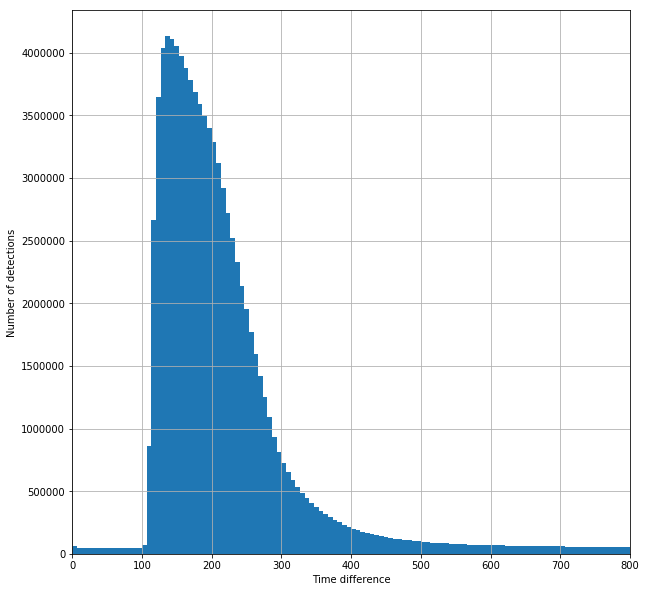

In [31]:
%%time
time_difference.hist(bins=150, figsize=(10,10))
plt.xlabel("Time difference")
plt.ylabel("Number of detections")
plt.xlim(0,800)

**Теперь построим без шумов.**

In [32]:
lpmt_energy = lpmt_hits.merge(train_info, left_on='event', right_on='evtID')
lpmt_energy.drop('evtID', axis=1, inplace=True)

In [33]:
gc.collect()

10590

In [34]:
lpmt_energy = lpmt_energy[lpmt_energy['isDN'] == False]

In [35]:
event = lpmt_energy.groupby('event')['hitTime'].min()

In [36]:
event = pd.DataFrame(event)
event['event_id'] = event.index
lpmt_energy = lpmt_energy.merge(event, left_on='event', right_on='event_id')

In [37]:
time_difference = lpmt_energy['hitTime_x'] - lpmt_energy['hitTime_y']

CPU times: user 2.34 s, sys: 228 ms, total: 2.57 s
Wall time: 1.53 s


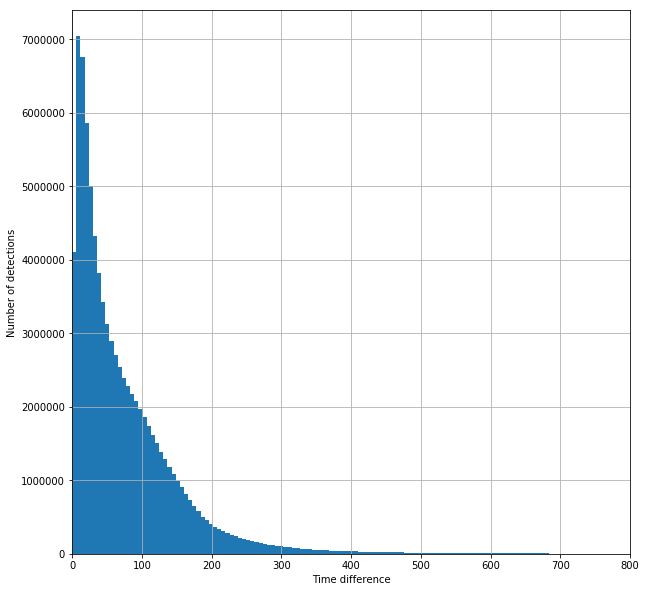

In [38]:
%%time
time_difference.hist(bins=150, figsize=(10,10))
plt.xlabel("Time difference")
plt.ylabel("Number of detections")
plt.xlim(0,800)

**Как видим в случае наличия шумов распределение похоже на правый кусок нормального, а в случае отсутствия шумов на экспоненциальное до 50, потом идет линейный спад примерно до 180, затем опять экспоненциально.**

**Среди больших детекторов при регистрации, большинство детекторов регистрирует ивент уже с небольшой задержкой. Затем идет быстрый экспоненциальный спад. Предположение: начиная с какого-то радиуса (предположительно радиус эффекта Вавилова-Черенкова от конкретного удара) начинается экспоненциальный спад попавших в детектор фотонов. При этом есть определенная небольшая зона, в которую сигнал идет быстрее чем в остальные, чем это обусловленно не понятно.**

**Проверим так же ли обстоят дела в маленьких детекторах**

In [39]:
gc.collect()

10464

In [40]:
spmt_energy = spmt_hits.merge(train_info, left_on='event', right_on='evtID')
spmt_energy.drop('evtID', axis=1, inplace=True)
spmt_energy = spmt_energy[spmt_energy['isDN'] == False]

In [41]:
sevent = pd.DataFrame(spmt_energy.groupby('event')['hitTime'].min())

In [42]:
sevent['event_id'] = sevent.index

In [43]:
sevent.dtypes

hitTime     float32
event_id      int64
dtype: object

In [44]:
spmt_energy = spmt_energy.merge(sevent, left_on='event', right_on='event_id')

In [45]:
spmt_energy.drop('event_id', axis=1, inplace=True)

In [46]:
spmt_energy[:3]

,event,hitTime_x,isDN,pmtID,E,R,x,y,z,hitTime_y
0,0,238.278091,False,311819,4.747791,14610.378,8290.779,11995.618,911.74286,24.623285
1,0,103.316055,False,307244,4.747791,14610.378,8290.779,11995.618,911.74286,24.623285
2,0,108.034225,False,323230,4.747791,14610.378,8290.779,11995.618,911.74286,24.623285


In [47]:
stime_difference = spmt_energy['hitTime_x'] - spmt_energy['hitTime_y']

CPU times: user 780 ms, sys: 4 ms, total: 784 ms
Wall time: 208 ms


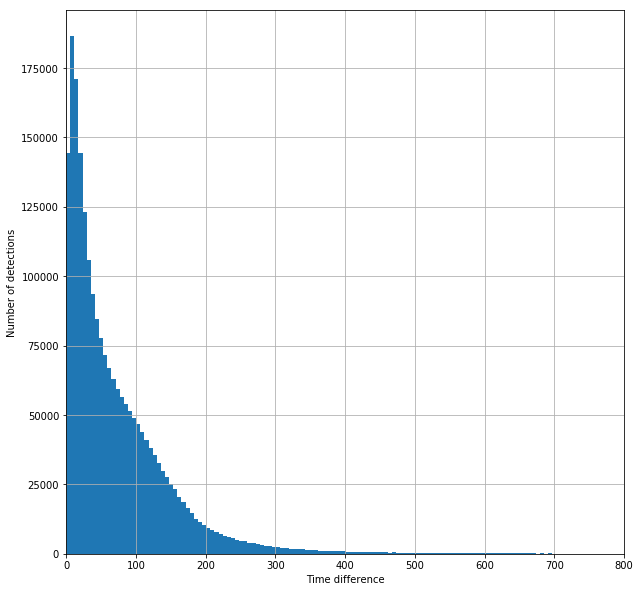

In [48]:
%%time
stime_difference.hist(bins=150, figsize=(10,10))
plt.xlabel("Time difference")
plt.ylabel("Number of detections")
plt.xlim(0,800)

**Как видим у маленьких детекторов все выглядит похоже. Примерно экспоненциальный спад до разницы в 50, затем линейная полоса почти до 200, а потом опять экспоненциальный спад. Так же на графике все же видна маленькая задержка вначале, по сравнению с первым детектором. Возможно, она связана с их устройством и задержкой детектирования.**

In [50]:
lpmt_energy[:3]

,event,hitTime_x,isDN,pmtID,E,R,x,y,z,hitTime_y,event_id
0,0,249.992615,False,14175,4.747791,14610.378,8290.779,11995.618,911.74286,24.005239,0
1,0,40.010311,False,17319,4.747791,14610.378,8290.779,11995.618,911.74286,24.005239,0
2,0,162.123199,False,16882,4.747791,14610.378,8290.779,11995.618,911.74286,24.005239,0


**Посмотрим как при детектировании меняется расстояние до детекторов, которые что-то регистрируют по времени.**

In [51]:
sample_event = lpmt_energy[lpmt_energy['event']==0]

In [52]:
sample_event.shape

(8168, 11)

In [53]:
lpmt_pos[:3]

,pmt_id,pmt_x,pmt_y,pmt_z
0,0,1049.0206,0.0000,19171.32
1,1,908.4785,524.5103,19171.32
2,2,524.5103,908.4785,19171.32


In [54]:
sample_merged = sample_event.merge(lpmt_pos, left_on='pmtID', right_on='pmt_id')

In [56]:
sample_merged.drop('pmtID',axis=1,inplace=True)

In [57]:
sample_merged[:3]

,event,hitTime_x,isDN,E,R,x,y,z,hitTime_y,event_id,pmt_id,pmt_x,pmt_y,pmt_z
0,0,249.992615,False,4.747791,14610.378,8290.779,11995.618,911.74286,24.005239,0,14175,-5411.832,16838.455,-7471.1797
1,0,92.820419,False,4.747791,14610.378,8290.779,11995.618,911.74286,24.005239,0,14175,-5411.832,16838.455,-7471.1797
2,0,40.010311,False,4.747791,14610.378,8290.779,11995.618,911.74286,24.005239,0,17319,12080.419,14903.949,-758.8111


In [58]:
sample_merged = sample_merged.sort_values('hitTime_x')

In [59]:
sample_merged[:3]

,event,hitTime_x,isDN,E,R,x,y,z,hitTime_y,event_id,pmt_id,pmt_x,pmt_y,pmt_z
1196,0,24.005239,False,4.747791,14610.378,8290.779,11995.618,911.74286,24.005239,0,8753,11456.047,15404.693,307.27652
347,0,24.081249,False,4.747791,14610.378,8290.779,11995.618,911.74286,24.005239,0,7872,10957.978,15623.919,2110.89580
1129,0,24.498110,False,4.747791,14610.378,8290.779,11995.618,911.74286,24.005239,0,8531,9898.779,16434.060,758.81110


In [97]:
def distances_from_start_detector(df):
    x_0, y_0, z_0 = df[['pmt_x', 'pmt_y', 'pmt_z']].values[0]
    R_n = np.sqrt((df['pmt_x'] - x_0) ** 2 + (df['pmt_y'] - y_0) ** 2 + (df['pmt_z'] - z_0) ** 2)
    return R_n

In [99]:
R_n = distances_from_start_detector(sample_merged)

In [100]:
R_n[:5]

1196       0.000000
347     1883.925496
1129    1920.563334
2560    1899.953457
5324     903.354943
dtype: float64

In [101]:
R_n.values

array([    0.        ,  1883.92549614,  1920.5633344 , ...,
       22953.32336106, 10316.59142442, 17066.13695039])

**Как видим, первыми после начального регистрируют не самые близкие детекторы**

Text(0,0.5,'Range')

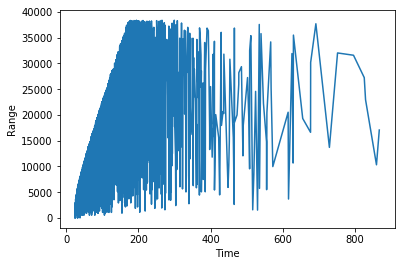

In [87]:
plt.plot(sample_merged['hitTime_x'].values, R_n.values)
plt.xlabel("Time")
plt.ylabel("Range")

**Как видим, график достаточно сложен. Вначале в среднем увеличивается радиус срабатывающих детекторов, но в то же время близкие детекторы продолжают регистрировать. Затем сигнал затухает, но затухает по всем расстояниям, наверное, это регистрируются вторичные явления, потому что четкой картины затухания нет. Посмотрим на 3D картинку по времени.**

In [88]:
x = sample_merged['pmt_x']
y = sample_merged['pmt_y']
z = sample_merged['pmt_z']

**За все время**

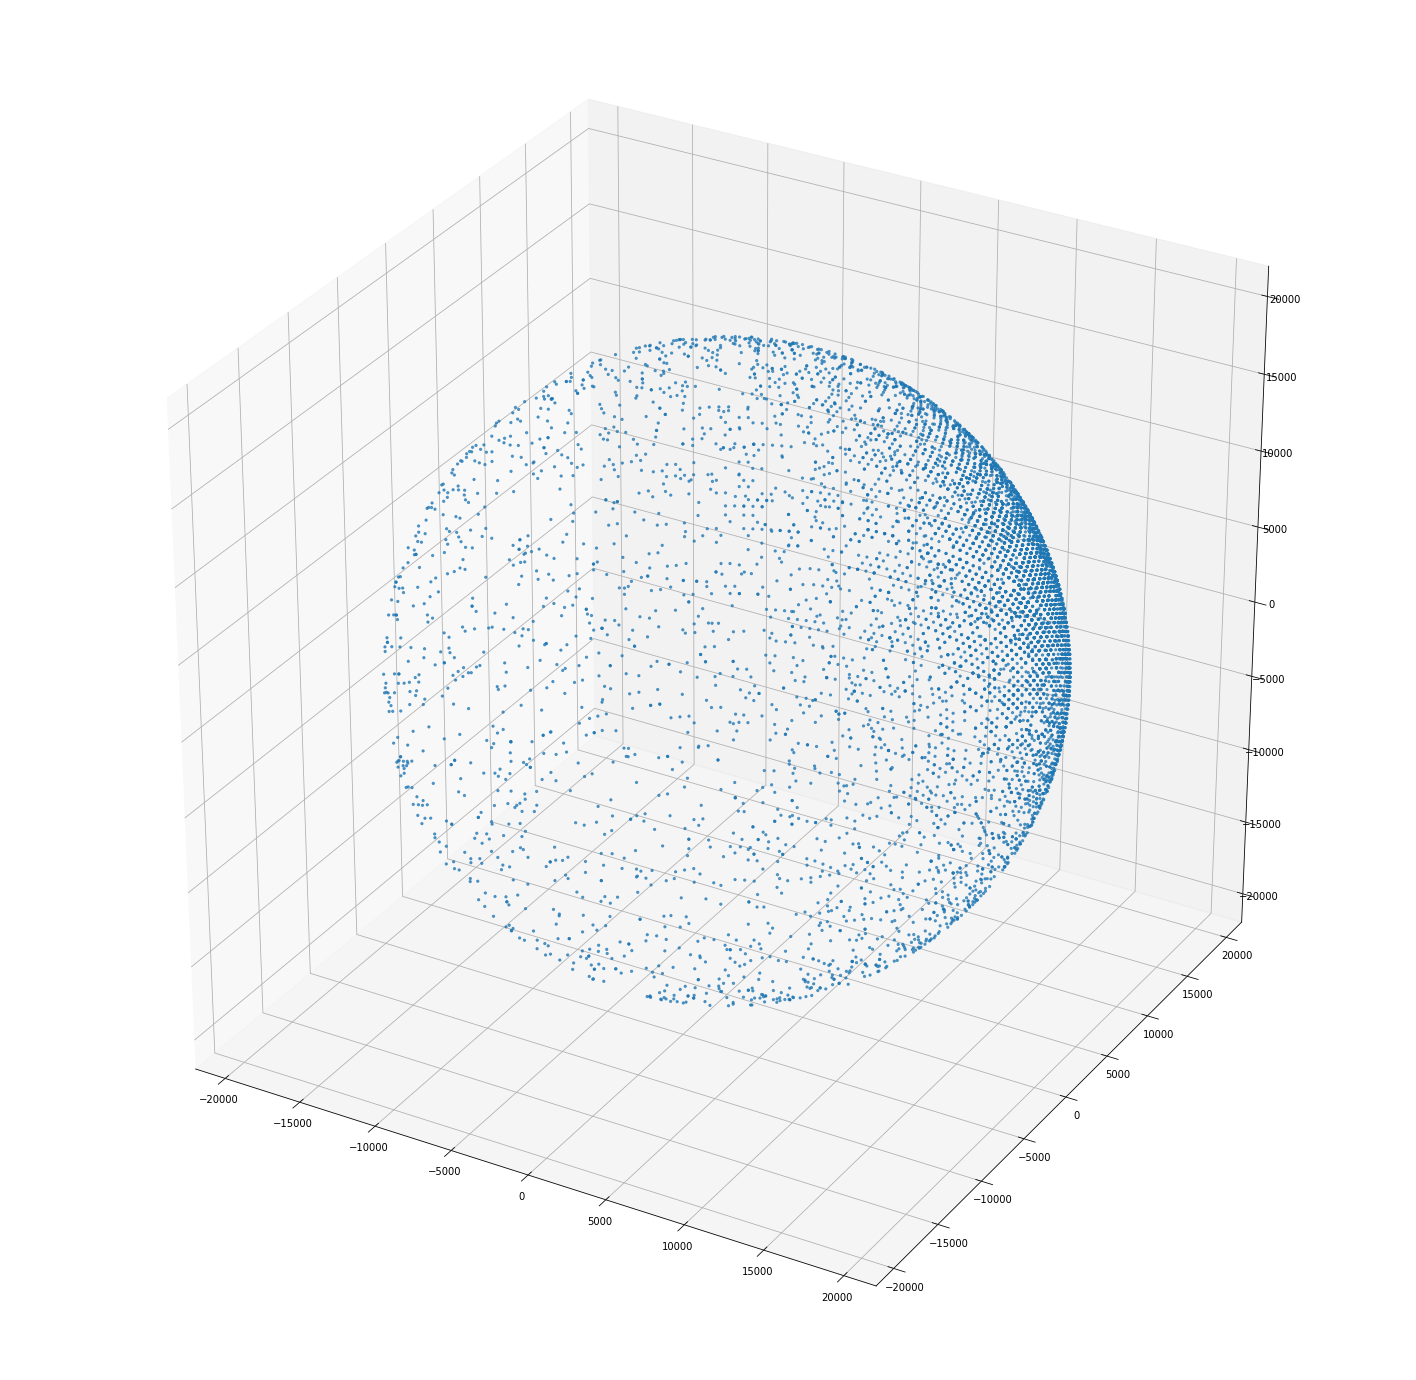

In [89]:
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, marker='o', s=5, alpha=0.7)

**Первые 50 регистраций**

In [90]:
first_n = 50

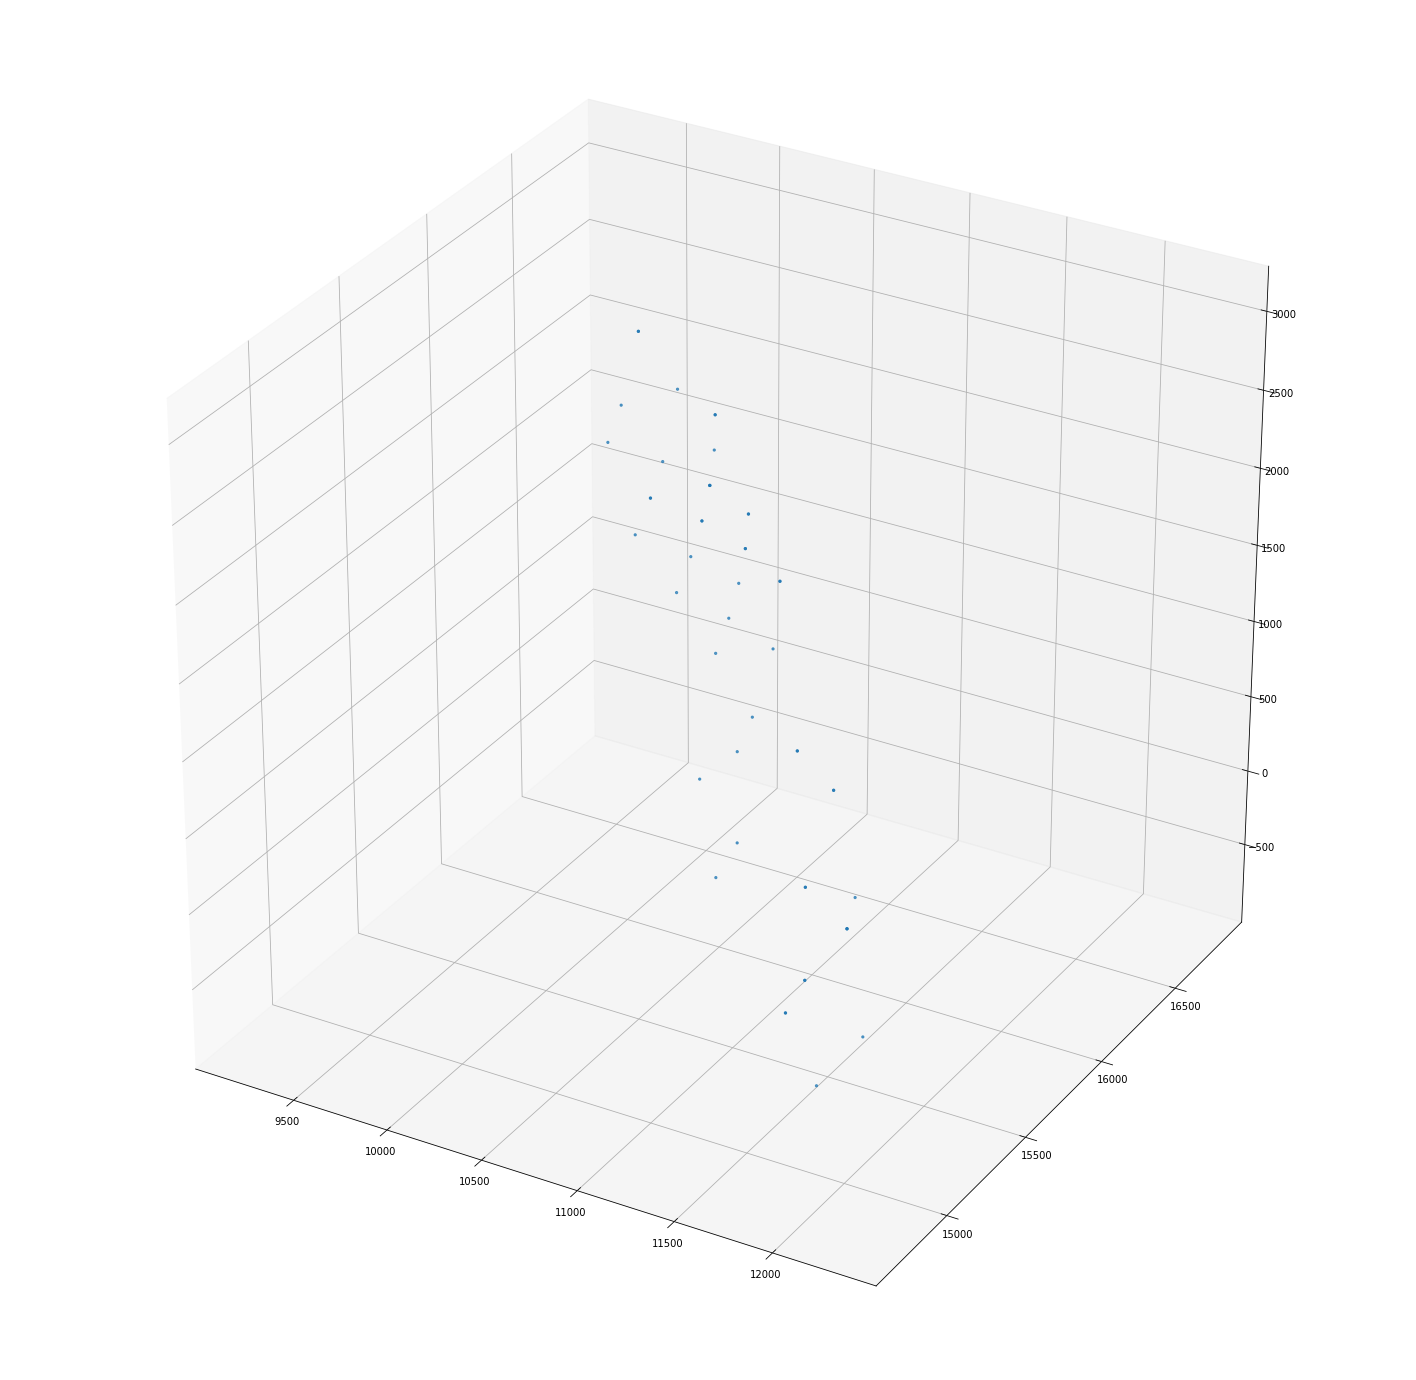

In [91]:
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:first_n], y[:first_n], z[:first_n], marker='o', s=5, alpha=0.7)

In [92]:
first_n = 200

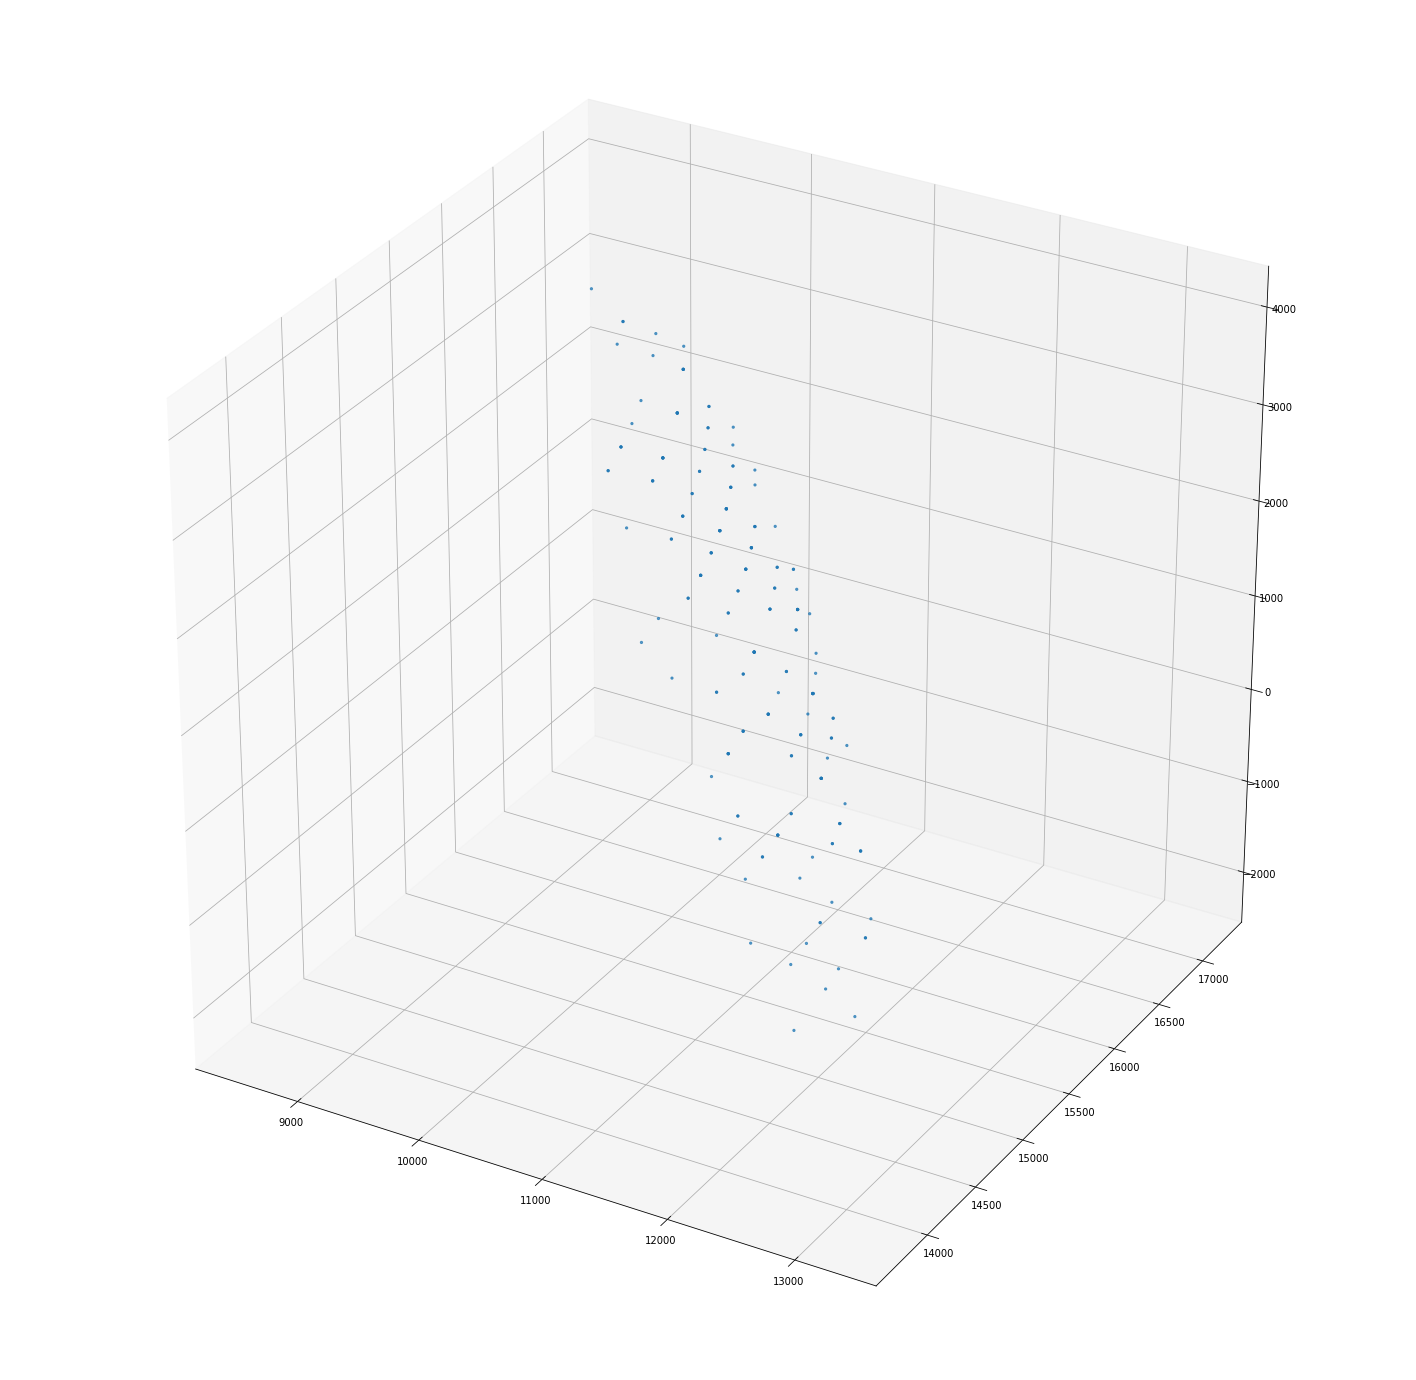

In [93]:
first_n = 200
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:first_n], y[:first_n], z[:first_n], marker='o', s=5, alpha=0.7)

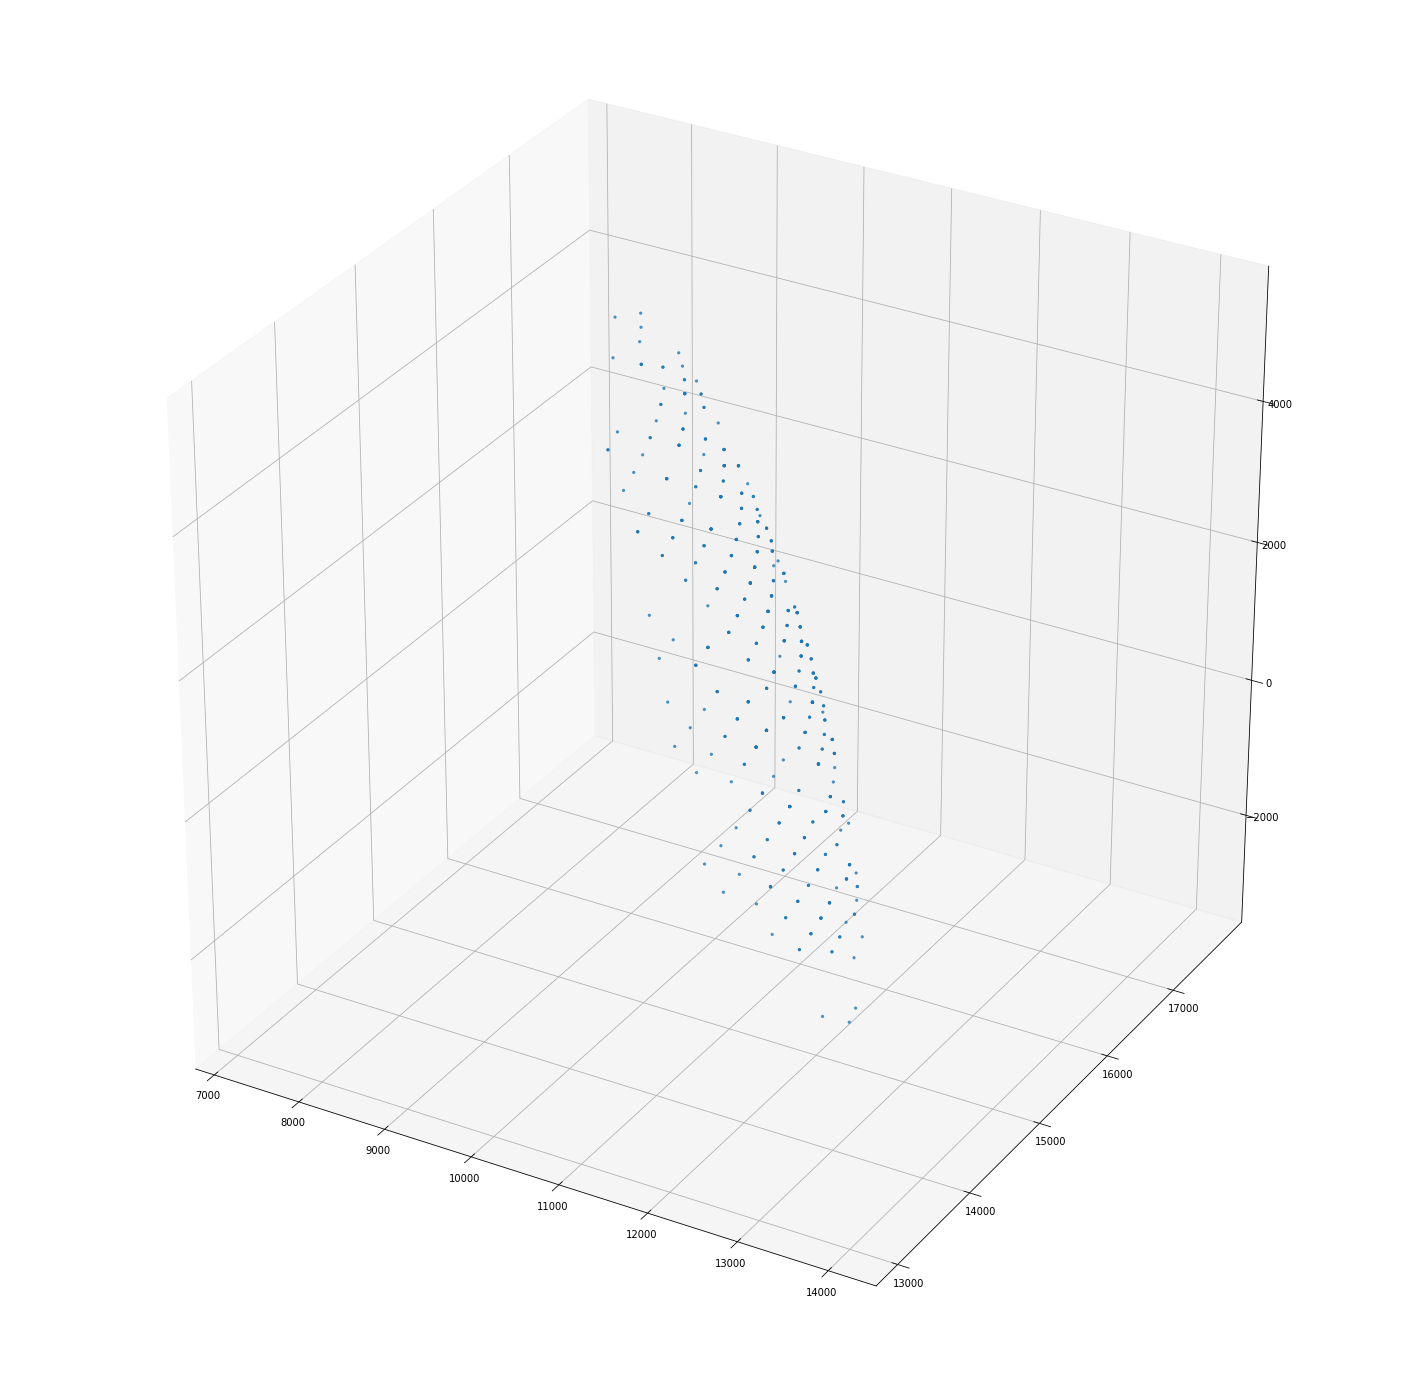

In [94]:
first_n = 500
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:first_n], y[:first_n], z[:first_n], marker='o', s=5, alpha=0.7)

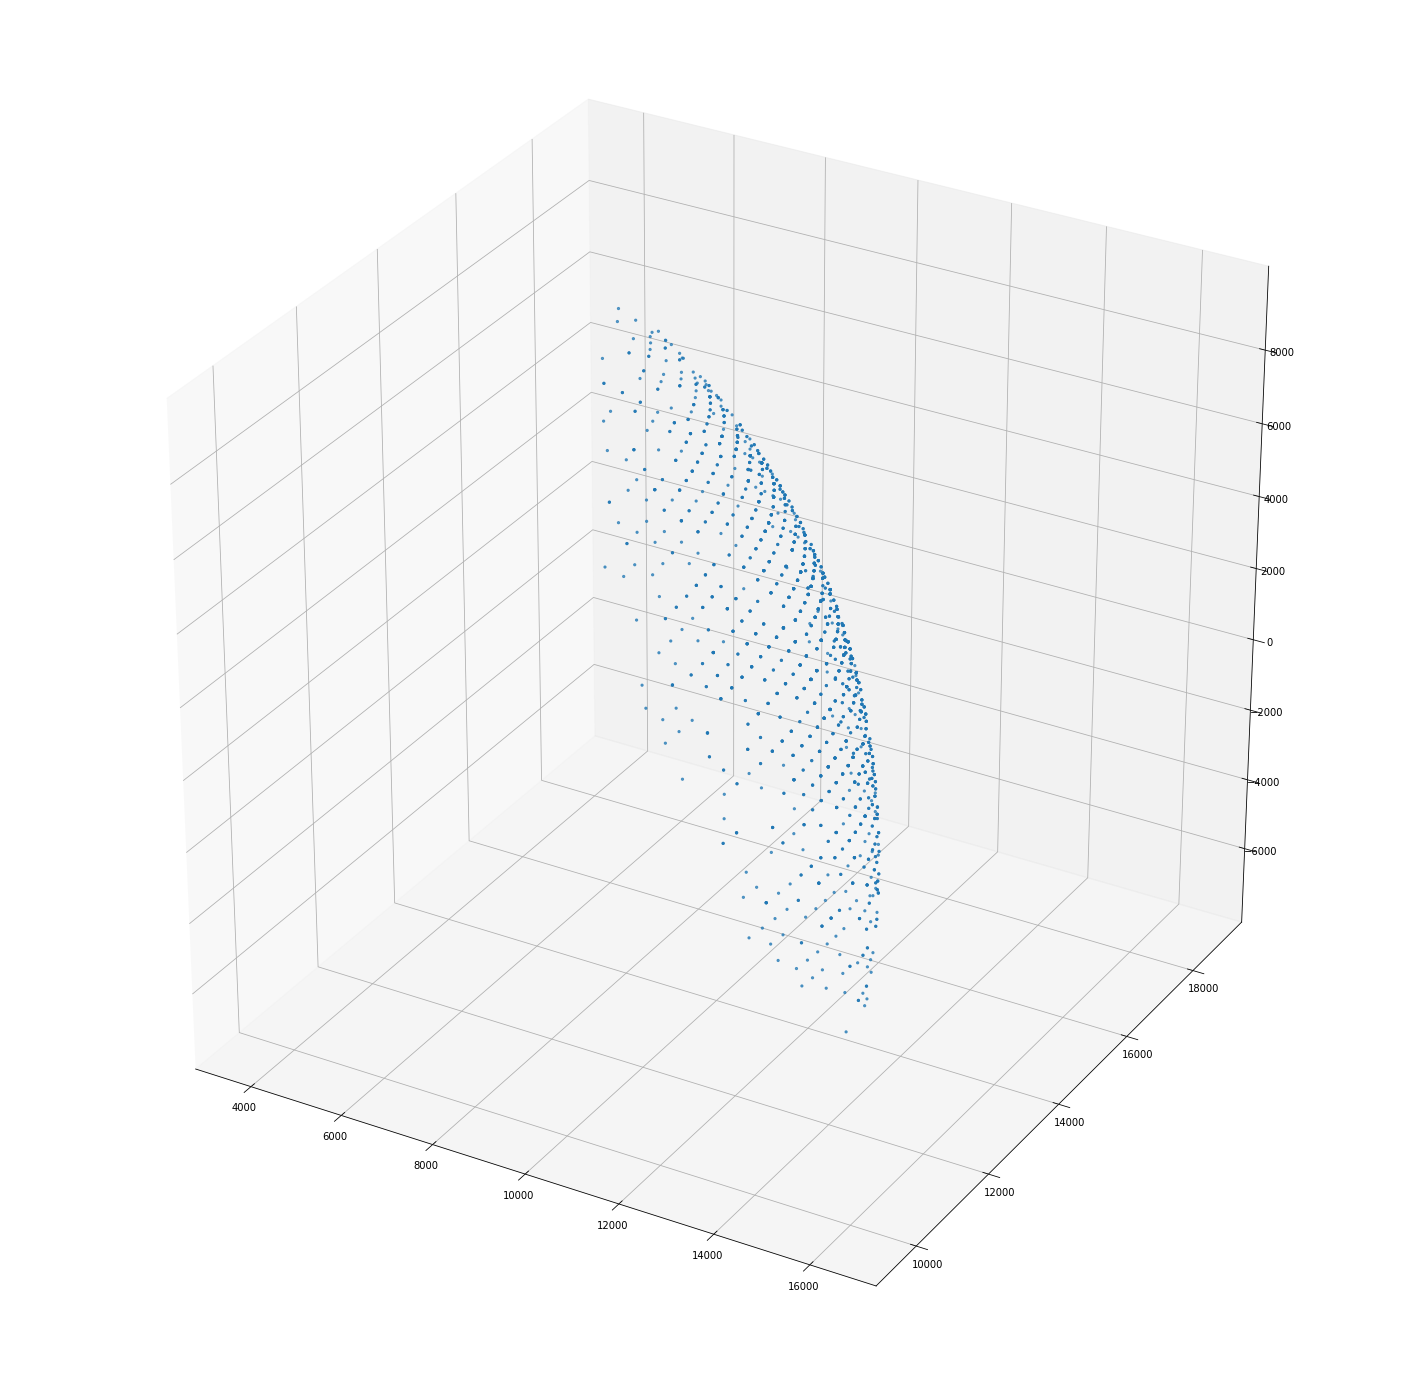

In [95]:
first_n = 2000
fig = plt.figure(figsize=(25, 25))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:first_n], y[:first_n], z[:first_n], marker='o', s=5, alpha=0.7)

**Как видим, сигнал приходит в виде чего-то похожего на конус. Вначале мы видим края, затем сигнал доходит до центра и мы начинаем видеть картину на всей поверхности сферы внутри этого конуса, однако те детекторы, которые фиксировали конус первыми (на краю) все еще продолжают видеть сигнал, какое-то время. Это можно учесть, во время генерации фичей.**

**Подготовим минидатасет для mybinder**

In [102]:
tynibinder = pd.read_hdf(DATA_DIR + 'train/train_lpmt_hits.h5', mode='r') 

In [103]:
tynibinder = tynibinder[tynibinder['event'] == 0]

In [104]:
tynibinder.shape

(8902, 4)

In [108]:
tynibinder.to_hdf(DATA_DIR + 'tinylpmt.h5', key='s')

In [109]:
tynibinder = pd.read_hdf(DATA_DIR + 'tinylpmt.h5', mode='r') 

In [110]:
tynibinder[:3]

,event,hitTime,isDN,pmtID
0,0,249.992615,False,14175
1,0,40.010311,False,17319
2,0,162.123199,False,16882
